In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans, HDBSCAN

In [36]:
data_path = "/home/chrhck/data/"
ds_paths = {
    "Northern Tracks":  os.path.join(data_path, "dataset_tracks_galactic.parquet"),
    "Cascades": os.path.join(data_path, "dataset_cscd_cascade_baseline_all_keys_galactic.parquet"),
    "Cascades Muon": os.path.join(data_path, "dataset_cscd_muon_baseline_all_keys_galactic.parquet"),
}
dataset = {}
for key, ds_path in ds_paths.items():
    #dataset[det] = {}
    data  = pd.read_parquet(ds_path)

    if "MCType" in data.columns:
        # MuonGun is added as a template in the fit
        Filter_muon_gun = data["MCType"] == "MuonGun"
        data = data[~Filter_muon_gun]
    if key == "Northern Tracks":
        reco_e = "energy_truncated"
        reco_zenith = "zenith_MPEFit"
    elif key == "Cascades" or key == "Cascades Muon":
        reco_e = 'energy_monopod'
        reco_zenith = 'zenith_monopod'
    dataset[key] = {
        "log10_true_energy": np.log10((np.asarray(data.MCPrimaryEnergy))),
        "log10_reco_energy": np.log10(np.asarray(data[reco_e])),
        "cos_reco_zenith": np.cos(np.asarray(data[reco_zenith])),
        "cos_true_zenith": np.cos(np.asarray(data.MCPrimaryZenith)),
        "baseline_weight": np.asarray(data.fluxless_weight),
        "conv_weight": np.asarray(data.mceq_conv_H4a_SIBYLL23c),
    }
    del data


/tmp/ipykernel_900/1593275841.py:24: RuntimeWarning: divide by zero encountered in log10
  "log10_reco_energy": np.log10(np.asarray(data[reco_e])),


In [37]:
X = np.concatenate([
    dataset["Northern Tracks"]["log10_reco_energy"][:, None],
    dataset["Northern Tracks"]["cos_reco_zenith"][:, None],
    dataset["Northern Tracks"]["log10_true_energy"][:, None],
    dataset["Northern Tracks"]["cos_true_zenith"][:, None],
], axis=1)
mask = np.all(np.isfinite(X), axis=1)
X = X[mask]




In [4]:
data = pd.read_parquet("../../NNMFit_testdata/src/NNMFit_testdata/data/datasets/Toise_ToyTracks/dataframe.parquet")
X = np.vstack([
    np.log10(np.asarray(data.reco_e)),
    np.cos(np.asarray(data.reco_zenith)),
    np.log10(np.asarray(data.true_e)),
    np.cos(np.asarray(data.true_z)),
]).T

X

array([[ 2.83511278e+00,  4.09735239e-03,  1.12697867e+00,
         9.99991606e-01],
       [ 3.02865352e+00, -2.27050344e-01,  1.26066358e+00,
         9.74334614e-01],
       [ 2.70500347e+00, -1.14259572e-01,  1.20027385e+00,
         9.93479474e-01],
       ...,
       [ 4.51371556e+00,  8.19713388e-02,  6.88287085e+00,
         9.96642231e-01],
       [ 4.21611849e+00,  1.86661513e-01,  6.86186209e+00,
         9.82629265e-01],
       [ 4.20392570e+00,  1.98353291e-01,  6.92660777e+00,
         9.80392399e-01]], shape=(98834, 4))

In [38]:
compression_rate = 0.1

n_clusters = int(np.ceil(X.shape[0] * compression_rate))

In [ ]:
clustering = MiniBatchKMeans(n_clusters=n_clusters, batch_size=8*1024, verbose=1).fit(X)

Init 1/1 with method k-means++


In [ ]:
clustering.labels_

array([4422, 4562, 6387, ..., 7784, 7784, 7784],
      shape=(98834,), dtype=int32)

In [ ]:
data

,true_e,true_z,reco_e,psi,weight_honda2006,weight_astro_E2,fluxless_weight,particle_type,e_smearing,e_scaling,...,true_ra,reco_ra,toy_reco_energy_exists,toy_reco_energy_fit_status,toy_reco_dir_exists,toy_reco_dir_fit_status,MCPrimaryType,MCPrimaryEnergy,MCPrimaryZenith,powerlaw
0,1.339611e+01,0.004097,6.840893e+02,0.944081,0.072395,1.289523e-07,4.628245e+03,2.0,1.027303,0.972158,...,1.428394,1.428394,1.0,0.0,1.0,0.0,14,1.339611e+01,1.566699,1.289523e-07
1,1.822483e+01,-0.227050,1.068202e+03,0.837968,0.074798,2.152531e-07,1.429903e+04,2.0,0.976962,1.036606,...,1.990251,1.990251,1.0,0.0,1.0,0.0,14,1.822483e+01,1.799844,2.152531e-07
2,1.585893e+01,-0.114260,5.069948e+02,1.175639,0.094377,2.387167e-07,1.200772e+04,2.0,0.909489,0.903218,...,5.009995,5.009995,1.0,0.0,1.0,0.0,14,1.585893e+01,1.685306,2.387167e-07
3,1.933383e+01,-0.045854,5.874768e+02,0.655226,0.098077,2.139109e-07,1.599185e+04,2.0,1.091051,1.039152,...,4.249033,4.249033,1.0,0.0,1.0,0.0,14,1.933383e+01,1.616666,2.139109e-07
4,1.849535e+01,0.061539,5.602834e+02,0.203665,0.085702,1.869204e-07,1.278826e+04,2.0,1.081210,1.097644,...,2.457414,2.457414,1.0,0.0,1.0,0.0,14,1.849535e+01,1.509219,1.869204e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98829,5.899108e+06,0.001921,1.122852e+03,0.094621,0.000040,3.991530e-02,2.778063e+20,3.0,1.062009,1.000970,...,3.768760,3.768760,1.0,0.0,1.0,0.0,-14,5.899108e+06,1.568876,3.991530e-02
98830,5.564366e+06,0.109474,6.466712e+06,0.014204,0.000023,3.525610e-02,2.183211e+20,3.0,1.001280,0.976855,...,6.109638,6.109638,1.0,0.0,1.0,0.0,-14,5.564366e+06,1.461103,3.525610e-02
98831,7.636087e+06,0.081971,3.263740e+04,0.021701,0.000020,3.402044e-02,3.967452e+20,3.0,1.070862,1.007546,...,2.411795,2.411795,1.0,0.0,1.0,0.0,-14,7.636087e+06,1.488733,3.402044e-02
98832,7.275487e+06,0.186662,1.644820e+04,0.079174,0.000013,3.352302e-02,3.548929e+20,3.0,0.972299,1.051710,...,2.743563,2.743563,1.0,0.0,1.0,0.0,-14,7.275487e+06,1.383033,3.352302e-02


In [ ]:
new_weights = np.bincount(clustering.labels_, weights=data["weight_honda2006"])


In [ ]:
clustering.cluster_centers_[:, 1]

array([-0.45722349,  0.07014686,  0.15298042, ...,  0.00458921,
       -0.11948427,  0.00130963], shape=(9884,))

In [ ]:
new_weights

array([0.40083843, 0.36673711, 0.48872442, ..., 0.33659426, 0.43163857,
       0.55096836], shape=(9884,))

In [ ]:
data

,true_e,true_z,reco_e,psi,weight_honda2006,weight_astro_E2,fluxless_weight,particle_type,e_smearing,e_scaling,...,true_ra,reco_ra,toy_reco_energy_exists,toy_reco_energy_fit_status,toy_reco_dir_exists,toy_reco_dir_fit_status,MCPrimaryType,MCPrimaryEnergy,MCPrimaryZenith,powerlaw
0,1.339611e+01,0.004097,6.840893e+02,0.944081,0.072395,1.289523e-07,4.628245e+03,2.0,1.027303,0.972158,...,1.428394,1.428394,1.0,0.0,1.0,0.0,14,1.339611e+01,1.566699,1.289523e-07
1,1.822483e+01,-0.227050,1.068202e+03,0.837968,0.074798,2.152531e-07,1.429903e+04,2.0,0.976962,1.036606,...,1.990251,1.990251,1.0,0.0,1.0,0.0,14,1.822483e+01,1.799844,2.152531e-07
2,1.585893e+01,-0.114260,5.069948e+02,1.175639,0.094377,2.387167e-07,1.200772e+04,2.0,0.909489,0.903218,...,5.009995,5.009995,1.0,0.0,1.0,0.0,14,1.585893e+01,1.685306,2.387167e-07
3,1.933383e+01,-0.045854,5.874768e+02,0.655226,0.098077,2.139109e-07,1.599185e+04,2.0,1.091051,1.039152,...,4.249033,4.249033,1.0,0.0,1.0,0.0,14,1.933383e+01,1.616666,2.139109e-07
4,1.849535e+01,0.061539,5.602834e+02,0.203665,0.085702,1.869204e-07,1.278826e+04,2.0,1.081210,1.097644,...,2.457414,2.457414,1.0,0.0,1.0,0.0,14,1.849535e+01,1.509219,1.869204e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98829,5.899108e+06,0.001921,1.122852e+03,0.094621,0.000040,3.991530e-02,2.778063e+20,3.0,1.062009,1.000970,...,3.768760,3.768760,1.0,0.0,1.0,0.0,-14,5.899108e+06,1.568876,3.991530e-02
98830,5.564366e+06,0.109474,6.466712e+06,0.014204,0.000023,3.525610e-02,2.183211e+20,3.0,1.001280,0.976855,...,6.109638,6.109638,1.0,0.0,1.0,0.0,-14,5.564366e+06,1.461103,3.525610e-02
98831,7.636087e+06,0.081971,3.263740e+04,0.021701,0.000020,3.402044e-02,3.967452e+20,3.0,1.070862,1.007546,...,2.411795,2.411795,1.0,0.0,1.0,0.0,-14,7.636087e+06,1.488733,3.402044e-02
98832,7.275487e+06,0.186662,1.644820e+04,0.079174,0.000013,3.352302e-02,3.548929e+20,3.0,0.972299,1.051710,...,2.743563,2.743563,1.0,0.0,1.0,0.0,-14,7.275487e+06,1.383033,3.352302e-02


In [ ]:
bins = np.linspace(-1, 1, 35)
bins

array([-1.        , -0.94117647, -0.88235294, -0.82352941, -0.76470588,
       -0.70588235, -0.64705882, -0.58823529, -0.52941176, -0.47058824,
       -0.41176471, -0.35294118, -0.29411765, -0.23529412, -0.17647059,
       -0.11764706, -0.05882353,  0.        ,  0.05882353,  0.11764706,
        0.17647059,  0.23529412,  0.29411765,  0.35294118,  0.41176471,
        0.47058824,  0.52941176,  0.58823529,  0.64705882,  0.70588235,
        0.76470588,  0.82352941,  0.88235294,  0.94117647,  1.        ])

In [ ]:
new_weights

array([0.40083843, 0.36673711, 0.48872442, ..., 0.33659426, 0.43163857,
       0.55096836], shape=(9884,))

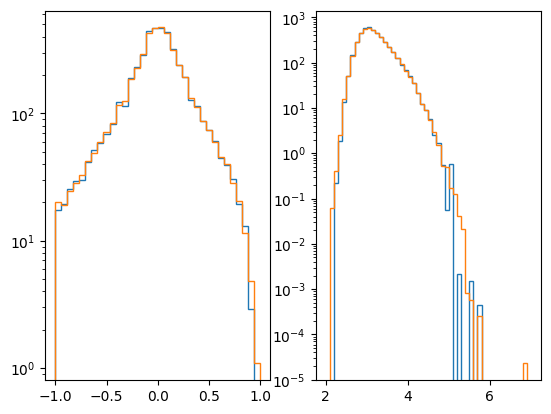

In [ ]:
fig, axs = plt.subplots(1, 2)
bins = np.linspace(-1, 1, 35)
axs[0].hist(clustering.cluster_centers_[:, 1], bins=bins, weights=new_weights, histtype="step")
axs[0].hist(np.cos(np.asarray(data.reco_zenith)), bins=bins, weights=np.asarray(data["weight_honda2006"]), histtype="step")
axs[0].set_yscale("log")

bins = np.linspace(2, 7, 51)
axs[1].hist(x=clustering.cluster_centers_[:, 0], bins=bins, weights=new_weights, histtype="step")
axs[1].hist(x=np.asarray(np.log10(data.reco_e)), bins=bins, weights=np.asarray(data["weight_honda2006"]), histtype="step")
axs[1].set_yscale("log")



In [78]:
hdb = HDBSCAN(min_cluster_size=5)
hdb.fit(X)

max_label = np.max(hdb.labels_)
# relabel noise points so that each noise point is in its own cluster

n_noise = np.sum(hdb.labels_ == -1)

cluster_labels = np.array(hdb.labels_, copy=True)
cluster_labels[cluster_labels == -1] = np.arange(max_label + 1, max_label + 1 + n_noise)

unique_labels = np.unique(cluster_labels)

In [79]:
compression_rate = len(unique_labels) / X.shape[0]
compression_rate

0.6833883076674019

In [80]:
compressed = np.zeros((unique_labels.shape[0], X.shape[1]))
compressed_weights = np.zeros((unique_labels.shape[0]))
for label in unique_labels:
    compressed[label] = np.average(X[cluster_labels == label], axis=0, weights=data["weight_honda2006"][cluster_labels == label])
    compressed_weights[label] = np.sum(data["weight_honda2006"][cluster_labels == label])


[]

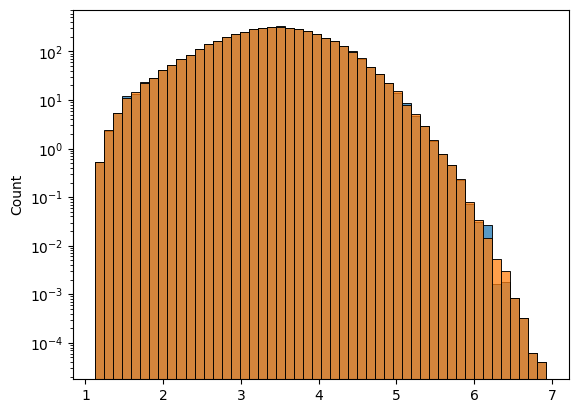

In [81]:
sns.histplot(x=compressed[:, 2], weights=compressed_weights, bins=50)
sns.histplot(x=X[:, 2], weights=data["weight_honda2006"], bins=50)
plt.semilogy()

In [53]:
np.sum(compressed_weights)

np.float64(4560.358402773817)

In [54]:
np.sum(data["weight_honda2006"])

np.float64(4560.358402773817)